Margaux Bailleul 21906121
Clémence CHESNAIS 21901191

# Import des modules

In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.snowball import FrenchStemmer 

In [12]:
!pip install -U spacy
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load('fr_core_news_sm')


     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     --------------------------------------- 0.0/16.3 MB 131.3 kB/s eta 0:02:04
     --------------------------------------- 0.0/16.3 MB 131.3 kB/s eta 0:02:04
     --------------------------------------- 0.0/16.3 MB 164.3 kB/s eta 0:01:39
     --------------------------------------- 0.0/16.3 MB 164.3 kB/s eta 0:01:39
     --------------------------------------- 0.1/16.3 MB 193.2 kB/s eta 0:01:24
     --------------------------------------- 0.1/16.3 MB 196.9 kB/s eta 0:01:23
     --------------------------------------- 0.1/16.3 MB 196.9 kB/s eta 0:01:23
      -------------------------------------- 0.2/16.3 MB 510.8 kB/s eta 0:00:32
     - -------------------------------------- 0.7/16.3 MB 1.4 MB/s eta 0:00:11
     ------- -------------------------------- 3.0/16.3 MB 5.9 MB/

# 1. Importation des données

In [3]:
# import du fichier csv
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

,Unnamed: 0,book_title,author,reader_review,rating,label
0,0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
4,4,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


Dans ce jeu de données nous disposons de 3 variables qualitatives et 2 variables quantitatives. 
Pour notre étude, nous avons le titre du livre, l'auteur, l'avis du lecteur, la note qu'il a attribué au livre ainsi qu'un label correspondant à la polarité de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est négatif, il vaut -1.

## 1.1. Statistiques descriptives

Nous regardons combien il y a d'avis pour chacune des polarités.

In [4]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

,nb_reviews
class,
1,6670
0,2129
-1,859


Dans ce jeu de données, il y a 6670 positifs, 2129 neutres et 859 négatifs.

Nous calculons le pourcentage d'avis pour chaque polarité.

In [5]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6670,0.69
0,2129,0.22
-1,859,0.09


Nous représentons sur un graphique la distributions des polarités selon le nombre d'avis de livre

<Axes: title={'center': "Nombre d'avis par classe"}, xlabel='class'>

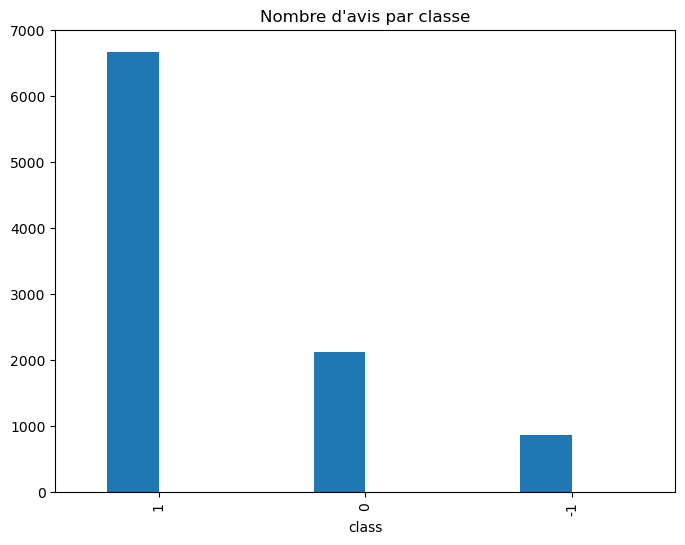

In [6]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

Nous affichons les 5 premiers avis pour voir à quoi ressemble les données.


In [8]:
for i in list(data['reader_review'][0:10]):
    print(i)
    print('------------------------')

Ce n'est pas le premier roman à aborder les thèmes lourds de l'inceste et de l'enfance martyre, mais il le fait avec une audace et un brio incomparables qui rendent ce livre marquant dans une vie de lecteur. On y sent à quel point l'auteur n'a pas cherché à "faire quelque chose", on ne sent jamais l'intention, on sent juste l'urgence, incandescente, à raconter la vérité d'un homme maltraité par la vie au point de dire à la nuit «  tu ne me feras pas peur j'ai plus de noir que toi dans mon enfance ».
------------------------
Simple, alias Barnabé, est un jeune homme de 22 ans qui a l’âge mental d’un enfant de 3 ans. Kléber, son frère de 17 ans, entre en terminale au lycée, mais décide de s’occuper lui-même de son frère. Leur mère étant morte et leur père refusant de s’encombrer de sa progéniture afin de vivre pleinement sa nouvelle vie, Kléber refuse d’abandonner son frère à Malicroix, l’institution où il dépérissait. Se mettant tant bien que mal à la recherche d’un appartement pour viv

On remarque que certains avis ne sont pas réellement des avis mais un résumé du livre. Ces derniers devront être classé dans la catégorie neutre.

# 1.2. Séparation des données

Nous séparons les données en deux jeux de données : un jeu d'entrainement et un jeu de test.

In [10]:
# On mélange les lignes du DataFrame
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# On utilise la fonction train_test_split pour diviser le DataFrame
train_df, test_df = train_test_split(data, train_size=2/3, random_state=42)

# On affiche les informations sur les ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 6438
Taille de l'ensemble de test : 3220


# 2. Prétraitement des données

## 2.1 Lemmatisation

Lemmatiser un texte implique de réduire chaque mot à sa forme de base ou à son "lemme".
Cela implique la suppression des variations grammaticales (comme les temps verbaux, les genres, les nombres, etc.) pour regrouper les mots qui ont la même signification de base

La lemmatisation est souvent utilisée pour améliorer la précision de l'analyse en réduisant les variations de mots à leur forme canonique. Cela aide à regrouper les mots apparentés et à réduire la complexité lors de l'analyse textuelle. 

In [27]:
def lemmatisation(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    return ' '.join(lemmas)

On applique la lemmatisation sur les avis des livres des jeux de données d'aprentissage et de test.

In [28]:
train_df['reader_review'] = train_df['reader_review'].fillna('')
train_df['reader_review'] = train_df['reader_review'].apply(lemmatisation)

8585    J’ avoir comme objectif de terminer le saga qu...
4891    un été pour mourir être son premier roman , et...
9347    il y avoir toujours un risque à passer d’ un r...
3838    ce livre pourtant écrire avant 2020 retracer u...
6398    Ouah ! je croire que ce être le premier legard...
Name: reader_review, dtype: object

In [ ]:
train_df['reader_review'].head()

Nous faisons la même chose pour le jeu de données de test.

In [29]:
test_df['reader_review'] = test_df['reader_review'].fillna('')
test_df['reader_review'] = test_df['reader_review'].apply(lemmatisation)

In [30]:
test_df['reader_review'].head()

3495    au commencemer ( de conte ) être le verbe et l...
8739    un écriture incisif et sombre , un scénario en...
3100    cela avoir être un tourbillon de émotion , com...
3862    Vivian MAIER , un talent anonyme ? plus tout à...
3686    Sylvie s’ être marier jeune , très jeune même ...
Name: reader_review, dtype: object

## 2.2. Racination

Nous racinisons les données pour réduire les mots à leur racine. Cela permet de réduire la complexité lors de l'analyse textuelle.

In [33]:
def stem_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stemmer = FrenchStemmer('french')
    stems = [stemmer.stem(token) for token in tokenizer.tokenize(text)]
    return ' '.join(stems)

In [34]:
train_df['stems'] = train_df['reader_review'].apply(stem_text)

In [35]:
train_df['stems'].head()

8585    j ’ avoir comm object de termin le sag que j ’...
4891    un été pour mour être son premi roman , et ce ...
9347    il y avoir toujour un risqu à pass d ’ un roma...
3838    ce livr pourt écrir avant 2020 retrac un cris ...
6398    ouah ! je croir que ce être le premi legardini...
Name: stems, dtype: object

Nous faisons la même chose pour le jeu de données de test.

In [36]:
test_df['stems'] = test_df['reader_review'].apply(stem_text)

In [37]:
test_df['stems'].head()

3495    au commencem ( de cont ) être le verb et le ve...
8739    un écritur incis et sombr , un scénario enchev...
3100    cel avoir être un tourbillon de émot , comm à ...
3862    vivian mai , un talent anonym ? plus tout à fa...
3686    sylv s ’ être mari jeun , tres jeun même , ave...
Name: stems, dtype: object

## 2.3. Etiqutage morphosyntaxique

In [38]:
def replace_words_with_pos_tag(text):
    text = nlp(text)
    return ' '.join([token.pos_ for token in text])

In [40]:
train_df['pos'] = train_df['reader_review'].apply(replace_words_with_pos_tag)

In [41]:
train_df['pos'].head()

8585    NOUN VERB VERB ADP NOUN ADP VERB DET NOUN SCON...
4891    DET NOUN ADP VERB AUX DET ADJ NOUN PUNCT CCONJ...
9347    PRON PRON VERB ADV DET NOUN ADP VERB ADP VERB ...
3838    DET NOUN ADV ADJ ADP NUM VERB DET NOUN ADJ PRO...
6398    PROPN PUNCT PRON VERB SCONJ PRON AUX DET ADJ N...
Name: pos, dtype: object

Nous faisons la même chose pour le jeu de données de test.

In [42]:
test_df['pos'] = test_df['reader_review'].apply(replace_words_with_pos_tag)

In [43]:
test_df["pos"].head()

3495    ADP VERB PUNCT ADP NOUN PUNCT AUX DET NOUN CCO...
8739    DET NOUN ADJ CCONJ NOUN PUNCT DET NOUN VERB PU...
3100    PRON VERB AUX DET NOUN ADP NOUN PUNCT ADP ADP ...
3862    PROPN PROPN PUNCT DET NOUN ADJ PUNCT ADV ADV A...
3686    PROPN PRON VERB AUX ADJ ADJ PUNCT ADV ADJ ADV ...
Name: pos, dtype: object